# Time series forecasting with GluonTS

The GluonTS toolkit contains components and tools for building time series models using MXNet. The models that are currently included are forecasting models but the components also support other time series use cases, such as classification or anomly detection. 

The toolkit is not intended as a forecasting solution for businesses or end users but it rather targets scientists and engineers who want to tweak algorithms or build and experiment with their own models.  

GluonTS contains:
- Components for building new models (likelihoods, feature processing pipelines, calendar features etc.)
- Data loading and processing
- A number of pre-build models
- Plotting and evaluation facilities
- Artificial and real datasets (only external datasets with blessed license)

In [1]:
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
from itertools import islice
from pathlib import Path

## Loading datasets

GluonTS comes with a number of publicly available datasets. 

In [2]:
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas

In [3]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['m4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly']


An available dataset can be easily downloaded by its name. If the dataset already exists locally it is not downloaded again by setting `regenerate=False`.

In [4]:
dataset = get_dataset("m4_hourly", regenerate=False)

INFO:root:using dataset already processed in path m4_hourly.


### What is in a dataset?

A `dataset` is an object that consists of three main components:
- `dataset.train` is an iterable collection of data entries used for training.
- `dataset.test` is an iterable collection of data entries used for inference. The test dataset is an extended version of the train dataset that contains a window in the end of each time series that was not seen during training. This window has length equal to the recommended prediction length.
- `dataset.metadata` containts metadata of the dataset such as the frequency of the time series, a recommended prediction horizon, associated features, etc. 

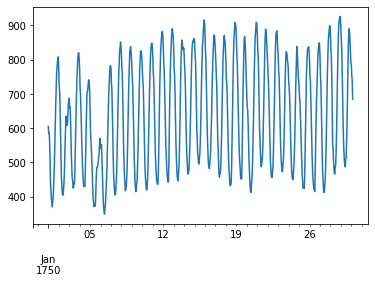

In [5]:
entry = next(iter(dataset.train))
train_series = to_pandas(entry)
train_series.plot()
plt.show()

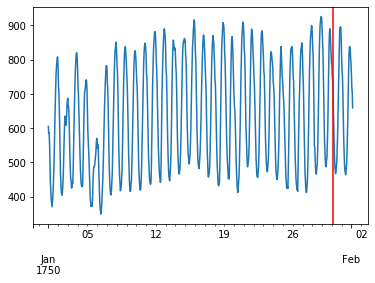

In [6]:
entry = next(iter(dataset.test))
test_series = to_pandas(entry)
test_series.plot()
plt.axvline(train_series.index[-1], color='r') # end of train dataset
plt.show()

In [7]:
print(f"Length of forecasting window in test dataset: {len(test_series) - len(train_series)}")
print(f"Recommended prediction horizon: {dataset.metadata.prediction_length}")
print(f"Frequency of the time series: {dataset.metadata.time_granularity}")

Length of forecasting window in test dataset: 48
Recommended prediction horizon: 48
Frequency of the time series: H


## Training an existing model (`Estimator`)

As we already mentioned, GluonTS comes with a number of pre-build models that can be used directly with minor hyperparameter configurations. For starters we will use one of these predefined models to go through the whole pipeline of training a model, predicting, and evaluating the results. 

GluonTS gives focus (but is not restricted) to probabilistic forecasting, i.e., forecasting the future distribution of the values and not the future values themselves (point estimates) of a time series. Having estimated the future distribution of each time step in the forecasting horizon, we can draw a sample from the distribution at each time step and thus create a "sample path", that can be seen as a possible realization of the future. In practice we draw multiple samples and create multiple sample paths which can be used for visualization, evalution of the model, to derive statistics, etc.

In this example we will use a simple pre-build feedforward neural network estimator that takes as input a window of length `context_length` and predicts the distribution of the values of the subsequent future window of length `prediction_length`. 

In general, each estimator (pre-build or custom) is configured by a number of hyperparameters that can be either common (but not binding) among all estimators (e.g. the `prediction_length`) or specific for the particular estimator (e.g. number of layers for a neural network or the stride in a CNN).

Finally, each estimator is configured by a `Trainer`, which defines how the model will be trained. i.e., the number of epochs, the learning rate, etc.  

In [8]:
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions

In [9]:
estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=dataset.metadata.prediction_length,
    context_length=100,
    freq=dataset.metadata.time_granularity,
    trainer=Trainer(ctx="cpu", epochs=5, learning_rate=1E-3, hybridize=True, num_batches_per_epoch=200,),
)

After specifing our estimator with all the necessary hyperparameters we can train it using our training dataset `dataset.train` just by invoking the `.train` method of the estimator. The training returns a predictor that can be used to predict.

In [10]:
predictor = estimator.train(dataset.train)

INFO:root:Start model training
INFO:root:Number of parameters in SimpleFeedForwardTrainingNetwork: 483
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 200/200 [00:01<00:00, 165.68it/s, avg_epoch_loss=5.13]
INFO:root:Epoch[0] Elapsed time 1.209 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=5.131169
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:01<00:00, 161.26it/s, avg_epoch_loss=4.71]
INFO:root:Epoch[1] Elapsed time 1.242 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=4.707615
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:01<00:00, 176.17it/s, avg_epoch_loss=4.62]
INFO:root:Epoch[2] Elapsed time 1.136 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=4.617970
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:01<00:00, 177.77it/s, avg_epoch_loss=4.52]
INFO:root:Epoch[3] Elapsed time 1.126 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=4.519839
INFO:root:Epoch[4] Le

Now we have a predictor in our hands. We can use it to predict the last window of the `dataset.test` and evaluate how our model performs.

GluonTS comes with the `make_evaluation_predictions` module that automates all this procedure. Roughly, this module performs the following steps:
- Removes the final window of length `prediction_length` of the `dataset.test` that we want to predict
- The estimator uses the remaining dataset to predict (in the form of sample paths) the "future" window that was just removed 
- The module outputs a generator over the forecasted sample paths and a generator over the `dataset.test` 

In [11]:
from gluonts.evaluation.backtest import make_evaluation_predictions

In [12]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,  # test dataset
    predictor=predictor,  # predictor
    num_eval_samples=100,  # number of sample paths
)

In [13]:
print(type(forecast_it))
print(type(ts_it))

<class 'generator'>
<class 'generator'>


First, we can convert these generators to lists to ease the subsequent computations.

In [14]:
forecasts = list(forecast_it)
tss = list(ts_it)

Now, let's see what do these lists contain under the hood. Let's start with the time series `tss` that is simpler. Each item in the `tss` list is just a pandas dataframe that contains the actual time series.

In [15]:
print(type(tss[0]))

<class 'pandas.core.frame.DataFrame'>


In [16]:
k = 3
tss[0].head(k)  # show the k first values

,0
1750-01-01 00:00:00,605.0
1750-01-01 01:00:00,586.0
1750-01-01 02:00:00,586.0


The `forecasts` list is a bit more complex. Each item in the `forecasts` list is an object that contains all the sample paths, the start date of the forecast, the frequency of the time series, etc. We can access all these information by simply invoking the corresponding attribute of the forecast object.

In [17]:
print(type(forecasts[0]))

<class 'gluonts.model.forecast.SampleForecast'>


In [18]:
print(f"Number of sample paths: {forecasts[0].num_samples}")
print(f"Start date of the forecast window: {forecasts[0].start_date}")
print(f"Frequency of the time series: {forecasts[0].freq}")

Number of sample paths: 100
Start date of the forecast window: 1750-01-30 04:00:00
Frequency of the time series: H


Apart from retrieving basic information we can do some more complex calculation such as to compute the mean or a given quantile of the values of the forecasted window.

In [19]:
print(f"Mean of the future window:\n {forecasts[0].mean}")
print(f"0.5-quantile (median) of the future window:\n {forecasts[0].quantile(0.5)}")

Mean of the future window:
 [672.2553  599.3473  536.7515  497.1709  488.08618 495.7713  515.9217
 527.07605 535.70337 591.1444  635.144   744.3088  775.3876  826.2952
 844.45483 900.8938  845.6406  849.4738  855.46326 846.2346  840.276
 757.0557  717.48517 700.3072  655.138   602.72345 601.4089  497.95343
 517.38354 478.3294  497.67603 523.44183 536.55164 562.21106 636.2518
 723.26117 751.1207  826.34674 853.336   902.36755 867.17267 847.4762
 900.47076 880.90765 787.6703  799.9709  778.22455 774.3356 ]
0.5-quantile (median) of the future window:
 [665.8682  595.03265 527.05133 502.48337 481.08084 490.982   515.0576
 538.3763  546.56396 592.1572  654.0227  736.7591  772.7448  812.0301
 847.85693 898.646   863.69257 866.52527 872.3111  831.0042  840.87177
 752.7025  716.5047  681.30804 635.6628  601.0972  604.29144 499.3432
 521.6302  470.99554 496.4999  539.38196 527.7248  581.33514 636.3042
 733.67676 737.51544 797.1997  858.85803 879.7304  888.91504 836.1305
 889.79034 877.6773  796

Finally, each forecast object has a `.plot` method that can be parametrized to show the mean, confidence intervals, etc.

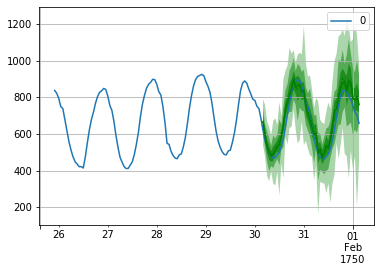

In [20]:
plot_length = 150 
tss[0][-plot_length:].plot()  # plot the time series
forecasts[0].plot(confidence_intervals=(50.0, 80.0, 95.0), # confidence intervals (plotted in different shades)
              show_mean=True,
              color='g')
plt.grid()
plt.show()

We can also evaluate the quality of our forecasts. The `Evaluator` returns aggregate error metrics as well as metric per time series which can be used e.g. for scatter plots.

In [21]:
from gluonts.evaluation import Evaluator

In [22]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset.test))

Running evaluation: 100%|██████████| 414/414 [00:02<00:00, 206.08it/s]


In [23]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 10346798.161604162,
    "abs_error": 9683036.858055115,
    "abs_target_sum": 145558863.59960938,
    "abs_target_mean": 7324.822041043146,
    "seasonal_error": 336.9046924038305,
    "MASE": 3.0548111359360766,
    "sMAPE": 0.17358305838137225,
    "MSIS": 34.71576698222386,
    "QuantileLoss[0.1]": 4238933.298757362,
    "Coverage[0.1]": 0.11297302737520129,
    "QuantileLoss[0.5]": 9683036.8694973,
    "Coverage[0.5]": 0.6092995169082126,
    "QuantileLoss[0.9]": 7145887.325456809,
    "Coverage[0.9]": 0.8893921095008053,
    "RMSE": 3216.64392832097,
    "NRMSE": 0.4391429457667589,
    "ND": 0.06652316883079253,
    "wQuantileLoss[0.1]": 0.029121780659248964,
    "wQuantileLoss[0.5]": 0.06652316890940116,
    "wQuantileLoss[0.9]": 0.049092766656334254,
    "mean_wQuantileLoss": 0.04824590540832813,
    "MAE_Coverage": 0.044293478260869545
}


In [24]:
item_metrics.head(10)

,Coverage[0.1],Coverage[0.5],Coverage[0.9],MASE,MSE,MSIS,QuantileLoss[0.1],QuantileLoss[0.5],QuantileLoss[0.9],abs_error,abs_target_mean,abs_target_sum,item_id,sMAPE,seasonal_error
0,0.062500,0.833333,1.0000,1.023385,2.749979e+03,5.952437,817.890533,2081.384491,1448.051257,2081.384277,659.250000,31644.0,NaN,0.065219,42.371302
1,0.354167,1.000000,1.0000,2.515401,1.749816e+05,16.604896,5017.354443,19935.015503,8668.200439,19935.015625,2586.437500,124149.0,NaN,0.156565,165.107988
2,0.000000,0.270833,0.8125,1.577852,2.712869e+04,9.271795,3215.794775,5974.811951,1781.193042,5974.812012,1354.791667,65030.0,NaN,0.086884,78.889053
3,0.041667,0.562500,1.0000,1.498675,2.254732e+05,7.219984,8195.044727,18630.245850,8181.887988,18630.246094,4912.145833,235783.0,NaN,0.077821,258.982249
4,0.020833,0.854167,1.0000,1.164758,8.284428e+04,6.709860,3858.055298,11209.303833,7569.772119,11209.303711,2731.000000,131088.0,NaN,0.078492,200.494083
5,0.000000,0.854167,1.0000,1.442652,1.342111e+05,11.035581,8846.158789,14741.067383,13706.234082,14741.067383,6320.395833,303379.0,NaN,0.048894,212.875740
6,0.000000,0.604167,1.0000,0.611283,2.992676e+06,7.360888,63698.369141,57148.207031,73934.071094,57148.207031,41360.937500,1985325.0,NaN,0.030470,1947.687870
7,0.000000,0.541667,1.0000,0.828344,3.030025e+06,6.850824,52638.917188,64572.867188,54171.083203,64572.867188,32098.041667,1540706.0,NaN,0.041672,1624.044379
8,0.020833,1.000000,1.0000,1.356164,7.580641e+06,6.659036,35976.462891,120491.718750,80640.289453,120491.718750,34184.583333,1640860.0,NaN,0.071411,1850.988166
9,0.000000,0.479167,1.0000,1.562485,5.408688e+02,14.926855,790.353345,789.489410,718.089288,789.489380,446.000000,21408.0,NaN,0.037167,10.526627


[]

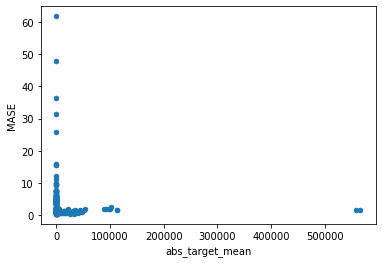

In [25]:
item_metrics.plot(x='abs_target_mean', y='MASE', kind='scatter')
plt.plot()

## Create your own forecast model

For creating your own forecast model you need to:
- define the training and prediction network
- define a new estimator that specifies any data processing and uses the networks

The training and prediction networks can be arbitrarily complex but they should follow some basic rules:
- Both should have a `hybrid_forward` method that defines what should happeni when the network is called    
- The trainng network's `hybrid_forward` should return a **loss** based on the prediction and the true values
- The prediction network's `hybrid_forward` should return the predictions 

For example, we can create a simple training network that defines a neural network with output dimension equal to `prediction_length` and uses the L1 loss in the `hybrid_forward` method, and a prediction network that is (and should be) identical to the training network (by inheriting the class).

In [26]:
class MyTrainNetwork(gluon.HybridBlock):
    def __init__(self, prediction_length, **kwargs):
        super().__init__(**kwargs)
        self.prediction_length = prediction_length
    
        with self.name_scope():
            # Set up a 3 layer neural network that directly predicts the target values
            self.nn = mx.gluon.nn.HybridSequential()
            self.nn.add(mx.gluon.nn.Dense(units=40, activation='relu'))
            self.nn.add(mx.gluon.nn.Dense(units=40, activation='relu'))
            self.nn.add(mx.gluon.nn.Dense(units=self.prediction_length, activation='softrelu'))

    def hybrid_forward(self, F, past_target, future_target):
        prediction = self.nn(past_target)
        # calculate L1 loss with the future_target to learn the median
        return (prediction - future_target).abs().mean(axis=-1)


class MyPredNetwork(MyTrainNetwork):
    # The prediction network only receives past_target and returns predictions
    def hybrid_forward(self, F, past_target):
        prediction = self.nn(past_target)
        return prediction.expand_dims(axis=1)

Now, we need to construct the estimator which should also follow some rules:
- It should include a `create_transformation` method that defines all the possible feature transformations and how the data is split during training
- It should include a `create_training_network` method that returns the training network configured with any necessary hyperparameters
- It should include a `create_predictor` method that creates the prediction network, and returns a `Predictor` object 

A `Predictor` defines the `predictor.predict` method of a given predictor. This method takes the test dataset, it passes it through the prediction network to take the predictions, and yields the predictions. You can think of the `Predictor` object as a wrapper of the prediction network that defines its `predict` method. 

Earlier, we used the `make_evaluation_predictions` to evaluate our predictor. Internally, the `make_evaluation_predictions` function invokes the `predict` method of the predictor to get the forecasts.

In [27]:
from gluonts.model.estimator import GluonEstimator
from gluonts.model.predictor import Predictor, RepresentableBlockPredictor
from gluonts.core.component import validated
from gluonts.support.util import copy_parameters
from gluonts.transform import ExpectedNumInstanceSampler, Transformation, InstanceSplitter, FieldName
from mxnet.gluon import HybridBlock

In [28]:
class MyEstimator(GluonEstimator):
    @validated()
    def __init__(
        self,
        freq: str,
        context_length: int,
        prediction_length: int,
        trainer: Trainer = Trainer()
    ) -> None:
        super().__init__(trainer=trainer)
        self.context_length = context_length
        self.prediction_length = prediction_length
        self.freq = freq
        
    
    def create_transformation(self):
        # Feature transformation that the model uses for input. 
        # Here we use a transformation that randomly select training samples from all time series.
        return InstanceSplitter(
                    target_field=FieldName.TARGET,
                    is_pad_field=FieldName.IS_PAD,
                    start_field=FieldName.START,
                    forecast_start_field=FieldName.FORECAST_START,
                    train_sampler=ExpectedNumInstanceSampler(num_instances=1),
                    past_length=self.context_length,
                    future_length=self.prediction_length,
                )
    
    def create_training_network(self) -> MyTrainNetwork:
        return MyTrainNetwork(
            prediction_length=self.prediction_length
        )

    def create_predictor(
        self, transformation: Transformation, trained_network: HybridBlock
    ) -> Predictor:
        prediction_network = MyPredNetwork(
            prediction_length=self.prediction_length
        )

        copy_parameters(trained_network, prediction_network)

        return RepresentableBlockPredictor(
            input_transform=transformation,
            prediction_net=prediction_network,
            batch_size=self.trainer.batch_size,
            freq=self.freq,
            prediction_length=self.prediction_length,
            ctx=self.trainer.ctx,
        )

Now, we can repeat the same pipeline as in the case we had a pre-build model: train the predictor, create the forecasts and evaluate the results.

In [29]:
estimator = MyEstimator(
    prediction_length=dataset.metadata.prediction_length,
    context_length=200,
    freq=dataset.metadata.time_granularity,
    trainer=Trainer(ctx="cpu", epochs=5, learning_rate=1E-3, hybridize=True, num_batches_per_epoch=200,),
)

In [30]:
predictor = estimator.train(dataset.train)

INFO:root:Start model training
INFO:root:Number of parameters in MyTrainNetwork: 128
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 200/200 [00:01<00:00, 189.28it/s, avg_epoch_loss=2.26e+03]
INFO:root:Epoch[0] Elapsed time 1.059 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=2263.184738
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 200/200 [00:01<00:00, 192.02it/s, avg_epoch_loss=1.01e+03]
INFO:root:Epoch[1] Elapsed time 1.043 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=1009.032958
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 200/200 [00:01<00:00, 187.57it/s, avg_epoch_loss=642]
INFO:root:Epoch[2] Elapsed time 1.067 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=642.340807
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 200/200 [00:01<00:00, 186.29it/s, avg_epoch_loss=581]
INFO:root:Epoch[3] Elapsed time 1.075 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=580.612765
INFO:root:Epoch[4] Lear

In [31]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test, 
    predictor=predictor, 
    num_eval_samples=100
)

In [32]:
forecasts = list(forecast_it)
tss = list(ts_it)

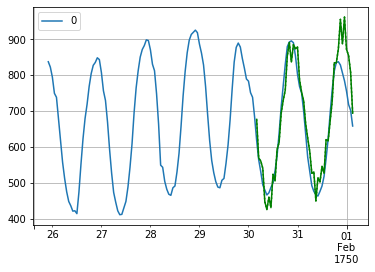

In [33]:
plot_length = 150 
tss[0][-plot_length:].plot()  # plot the time series
forecasts[0].plot(confidence_intervals=(50.0, 80.0, 95.0), # confidence intervals (plotted in different shades)
              show_mean=True,
              color='g')
plt.grid()
plt.show()

We observe from the plot above that we cannot actually see any confidence interval in the predictions. This is expected since the networks that we defined do not do probabilistic forecasting but they just give point estimates. That is, the prediction netwrok does not return samples from a learned distribution. Rather, for a fixed input the network gives always the same output. So, by requiring 100 sample paths in such a network, we get 100 times the same output.

In [34]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset.test))

Running evaluation: 100%|██████████| 414/414 [00:01<00:00, 219.24it/s]


In [35]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 10784598.498202413,
    "abs_error": 10850433.669557571,
    "abs_target_sum": 145558863.59960938,
    "abs_target_mean": 7324.822041043146,
    "seasonal_error": 336.9046924038305,
    "MASE": 4.210994169278303,
    "sMAPE": 0.21086247986959086,
    "MSIS": 168.43976703645237,
    "QuantileLoss[0.1]": 15180961.352627182,
    "Coverage[0.1]": 0.5468498389694041,
    "QuantileLoss[0.5]": 10850433.535581589,
    "Coverage[0.5]": 0.5468498389694041,
    "QuantileLoss[0.9]": 6519905.718535997,
    "Coverage[0.9]": 0.5468498389694041,
    "RMSE": 3283.991245147041,
    "NRMSE": 0.4483373420877485,
    "ND": 0.07454326999559434,
    "wQuantileLoss[0.1]": 0.10429431074967477,
    "wQuantileLoss[0.5]": 0.07454326907516957,
    "wQuantileLoss[0.9]": 0.044792227400664415,
    "mean_wQuantileLoss": 0.07454326907516957,
    "MAE_Coverage": 0.28228327965646804
}


In [36]:
item_metrics.head(10)

,Coverage[0.1],Coverage[0.5],Coverage[0.9],MASE,MSE,MSIS,QuantileLoss[0.1],QuantileLoss[0.5],QuantileLoss[0.9],abs_error,abs_target_mean,abs_target_sum,item_id,sMAPE,seasonal_error
0,0.625000,0.625000,0.625000,1.022425,3.244689e+03,40.896998,2948.627197,2079.430908,1210.234619,2079.430664,659.250000,31644.0,NaN,0.064549,42.371302
1,0.958333,0.958333,0.958333,2.389929,1.955750e+05,95.597149,33815.886426,18940.623535,4065.360645,18940.625000,2586.437500,124149.0,NaN,0.141774,165.107988
2,0.229167,0.229167,0.229167,1.883838,3.211818e+04,75.353518,2320.629614,7133.482056,11946.334497,7133.481934,1354.791667,65030.0,NaN,0.107322,78.889053
3,0.479167,0.479167,0.479167,1.353974,2.355648e+05,54.158967,16328.410156,16831.453125,17334.496094,16831.453125,4912.145833,235783.0,NaN,0.074174,258.982249
4,0.708333,0.708333,0.708333,1.069721,8.102356e+04,42.788845,14608.784595,10294.691528,5980.598462,10294.691406,2731.000000,131088.0,NaN,0.079557,200.494083
5,0.604167,0.604167,0.604167,2.191272,3.000220e+05,87.650881,26342.642676,22390.494629,18438.346582,22390.496094,6320.395833,303379.0,NaN,0.075070,212.875740
6,0.500000,0.500000,0.500000,0.949742,5.178492e+06,37.989671,83512.675781,88790.425781,94068.175781,88790.429688,41360.937500,1985325.0,NaN,0.047898,1947.687870
7,0.458333,0.458333,0.458333,1.071896,4.903515e+06,42.875839,62498.805859,83558.716797,104618.627734,83558.718750,32098.041667,1540706.0,NaN,0.052686,1624.044379
8,0.833333,0.833333,0.833333,1.663020,1.416581e+07,66.520786,253631.839453,147755.025391,41878.211328,147755.031250,34184.583333,1640860.0,NaN,0.083680,1850.988166
9,0.354167,0.354167,0.354167,1.724453,4.629092e+02,68.978133,606.399097,871.328491,1136.257886,871.328491,446.000000,21408.0,NaN,0.041534,10.526627


[]

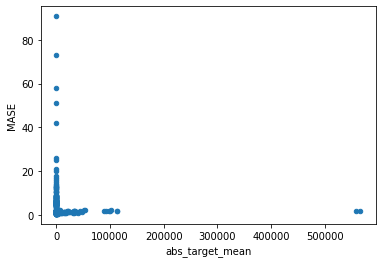

In [37]:
item_metrics.plot(x='abs_target_mean', y='MASE', kind='scatter')
plt.plot()